In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
from prophet.plot import plot_plotly, plot_components_plotly
from prophet import Prophet

C:\Users\sahit\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [65]:
url = 'https://www.gobankingrates.com/saving-money/food/price-coffee-year-were-born/?utm_campaign=850937&utm_source=yahoo.com&utm_content=6'
html = requests.get(url)
soup = BeautifulSoup(html.content, 'html.parser')


In [66]:
# Find all <div> tags with class "wp-block-group__inner-container"
div_tags = soup.find_all('div', class_='wp-block-group__inner-container')

data_list=[]
# Loop through each <div> tag and extract the text from <p> tags starting with "Cost of Coffee in"
for div_tag in div_tags:
    p_tags = div_tag.find_all('p')
    for p_tag in p_tags:
        if p_tag.text.startswith("Cost of Coffee in"):
            data_list.append(p_tag.text.strip())

In [67]:

# Initialize lists to store year and price
years = []
prices = []

# Process each line separately
for line in data_list:
    # Split the line by ":"
    split_line = line.split(":")
    
    # Extract year and price
    year = split_line[0].split()[-1]
    price = split_line[1].strip().split('$')[-1]
    
    # Append year and price to lists
    years.append(year)
    prices.append(price)

# Create a DataFrame from the lists
df = pd.DataFrame({'Year': years, 'Price': prices})


In [68]:
df['Price'] = pd.to_numeric(df['Price'])

In [69]:
df

,Year,Price
0,1940,0.16
1,1941,0.17
2,1942,0.19
3,1943,0.20
4,1944,0.20
...,...,...
71,2011,2.56
72,2012,2.62
73,2013,2.65
74,2014,2.70


In [70]:
new_data = {'Year': [2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
            'Price': [2.74,2.81,2.88,2.92,2.99, 3.04, 3.28, 3.48, 3.59  ]}
new_df = pd.DataFrame(new_data)

In [71]:
df = pd.concat([df, new_df], ignore_index=True)

In [72]:
df

,Year,Price
0,1940,0.16
1,1941,0.17
2,1942,0.19
3,1943,0.20
4,1944,0.20
...,...,...
80,2020,2.99
81,2021,3.04
82,2022,3.28
83,2023,3.48


In [73]:
df.reset_index(drop=True, inplace=True)

In [74]:
df.columns = ['ds','y']

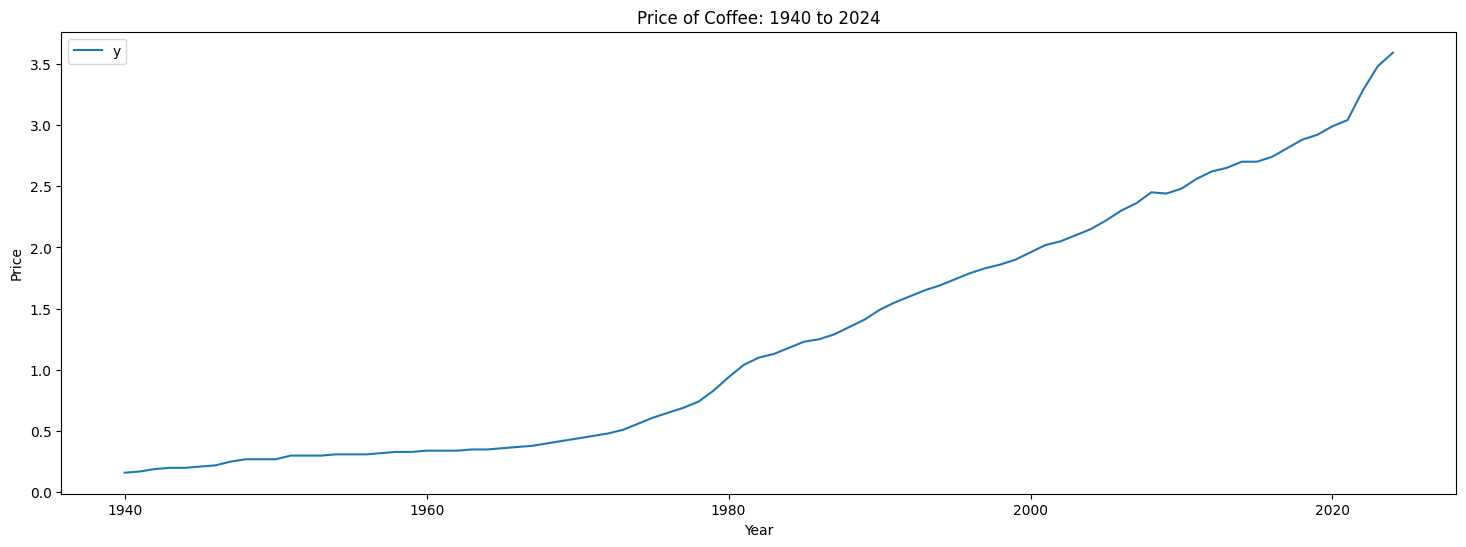

In [92]:
df.plot(x='ds',y='y',figsize=(18,6))
plt.xlabel('Year')
plt.ylabel('Price')
plt.title('Price of Coffee: 1940 to 2024')

# Display the plot
plt.show()

In [76]:
train = df.iloc[:len(df)-20]
test = df.iloc[len(df)-20:]

In [77]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=20, freq = "Y") #MS for monthly, H for hourly
forecast = m.predict(future)

19:37:15 - cmdstanpy - INFO - Chain [1] start processing
19:37:15 - cmdstanpy - INFO - Chain [1] done processing


In [78]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1940-01-01,0.143427,0.147014,0.186278,0.143427,0.143427,0.022099,0.022099,0.022099,0.022099,0.022099,0.022099,0.0,0.0,0.0,0.165526
1,1941-01-01,0.154479,0.157166,0.197361,0.154479,0.154479,0.023187,0.023187,0.023187,0.023187,0.023187,0.023187,0.0,0.0,0.0,0.177666
2,1942-01-01,0.165501,0.165483,0.205929,0.165501,0.165501,0.019951,0.019951,0.019951,0.019951,0.019951,0.019951,0.0,0.0,0.0,0.185453
3,1943-01-01,0.176523,0.176732,0.216186,0.176523,0.176523,0.019593,0.019593,0.019593,0.019593,0.019593,0.019593,0.0,0.0,0.0,0.196116
4,1944-01-01,0.187545,0.190098,0.231037,0.187545,0.187545,0.022099,0.022099,0.022099,0.022099,0.022099,0.022099,0.0,0.0,0.0,0.209644


In [79]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
80,2019-12-31,2.956016,2.810825,3.086382
81,2020-12-31,2.970854,2.806566,3.112698
82,2021-12-31,3.026624,2.852211,3.181222
83,2022-12-31,3.085190,2.894669,3.253156
84,2023-12-31,3.146519,2.943086,3.343469


In [80]:
plot_plotly(m ,forecast)
     

In [81]:
from statsmodels.tools.eval_measures import rmse

In [84]:
predictions = forecast.iloc[-20:]['yhat']

In [85]:
print("Root Mean Squared Error between actual and  predicted values: ",rmse(predictions,test['y']))
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Squared Error between actual and  predicted values:  0.1494723685131833
Mean Value of Test Dataset: 2.7604999999999995


In [89]:
m = Prophet()
m.fit(train)
future = m.make_future_dataframe(periods=47, freq = "Y") #MS for monthly, H for hourly
forecast = m.predict(future)

19:38:17 - cmdstanpy - INFO - Chain [1] start processing
19:38:17 - cmdstanpy - INFO - Chain [1] done processing


In [90]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
107,2046-12-31,4.228208,3.678180,4.862900
108,2047-12-31,4.289537,3.713436,4.928680
109,2048-12-31,4.304375,3.705034,4.981683
110,2049-12-31,4.360145,3.733120,5.060615
111,2050-12-31,4.418711,3.766922,5.134973


In [97]:
plot_plotly(m ,forecast, xlabel='Year', ylabel='Price')
   